# Import packages

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.spatial.distance import jensenshannon
from itertools import combinations_with_replacement, product
from tqdm.notebook import tqdm

# Define useful functions

In [2]:
# The types of data we will be working with
types = ["0.2ng", "2ng", "sc", "bulk"]

In [3]:
def plot_peptide_length_distribution(df, out_file=None):
    min_length = df["peptide_length"].min()
    max_length = df["peptide_length"].max()
    num_bins = max_length - min_length + 1

    fig, axs = plt.subplots(2,2,sharey=True)
    axs = axs.flatten()

    for type, ax in zip(types,axs):
        ax.hist(df.loc[df["type"]==type, "peptide_length"], bins=num_bins, range=(min_length-.5, max_length+.5), density=True)
        ax.set_title("Histogram for " + type + " data")
        ax.set_xlabel("Peptide Length")
        ax.set_ylabel("Frequency")

    fig.tight_layout()
    if out_file is not None:
        plt.savefig(out_file)
    plt.show()


In [4]:
# This is looking better, but we should probably play it safe and sample from a 
# "mean distribution" to get all of the distributions looking the same.
def find_mean_distribution(peptide_lengths):
    min_length = peptide_lengths["peptide_length"].min()
    max_length = peptide_lengths["peptide_length"].max()
    num_bins = max_length - min_length + 1

    distributions = []
    for datatype in types:
        dist = np.histogram(peptide_lengths.loc[peptide_lengths["type"]==datatype, "peptide_length"], bins=num_bins, range=(min_length-.5, max_length+.5), density=True)[0]
        distributions.append(dist)

    distributions = np.array(distributions)

    mean_dist = distributions.mean(axis=0)

    # We will also only consider values that can possibly be sampled.
    # I.e. If one of the distributions does not have any length 25 peptides, we can't sample from it there.
    # Thus, set those, if any, to have zero probability and rescale the mean distribution

    threshold = 1e-14 # Threshold to handle roundoff
    impossible = np.any(distributions <= threshold, axis=0)

    mean_dist[impossible] = 0

    # Rescale to probability 1
    mean_dist *= 1/np.sum(mean_dist)

    return mean_dist

def plot_distribution(mean_dist, dist_range, outfile=None):
    min_length, max_length = dist_range
    plt.bar(range(min_length, max_length+1), mean_dist, width=1)
    plt.title("The mean distribution of peptide lengths")
    if outfile is not None:
        plt.savefig(outfile)
    plt.show()

In [62]:
def get_proportions_df(df):
    df = get_counts_df(df)
    df["total"] = np.sum(df["counts"])
    df["counts"] = df["counts"] / df["total"]
    df = df.drop(columns=["total"])

    return df

def get_counts_df(df):
    df = df.copy()
    
    types = pd.unique(df["type"])
    intensities = pd.unique(df["Intensity"])
    sectors = pd.unique(df["sector"])

    df["counts"] = 1
    # This is to ensure that every possibility shows up in the dataframe.
    temp_df = pd.DataFrame(data=product(types, intensities, sectors, [0]),  columns=["type", "Intensity", "sector", "counts"])
    temp_df = temp_df.set_index(["type", "Intensity", "sector"])
    df = temp_df + df.groupby(["type","Intensity","sector"]).sum()
    df.sort_index(inplace=True)
    df = df.reset_index()
    
    return df

In [6]:

def sample_to_distribution(peptide_lengths, mean_dist, random_state):
    min_length = peptide_lengths["peptide_length"].min()
    max_length = peptide_lengths["peptide_length"].max()
    num_bins = max_length - min_length + 1

    keep_percentages = []
    chosen_peptides = []
    for datatype in types:
        # Filter to only what we need
        filtered_df = peptide_lengths.loc[peptide_lengths["type"] == datatype]

        # Get counts of the number of peptides
        peptide_counts = np.histogram(filtered_df.loc[:, "peptide_length"], bins=num_bins, range=(min_length-.5, max_length+.5))[0]
        total_peptides = np.sum(peptide_counts)
        
        # Sample from a multinomial distribution with n = total_peptides
        samples = stats.multinomial.rvs(total_peptides, p=mean_dist, random_state=random_state)

        # print(peptide_counts)
        # print(samples)
        # Find out what percent of the original data we get to keep
        # The closer the distribution is to the mean distribution, the more of it we get to keep
        keep_ratio = np.max(samples[peptide_counts != 0] / peptide_counts[peptide_counts != 0])
        samples = (samples/keep_ratio).astype(int) # Keep them integers

        kept_peptides = np.sum(samples)

        # The percentage of data from this datatype that is kept once we're done sampling
        keep_percentages.append(kept_peptides/total_peptides)

        # Sample from the original distributions
        for N, pep_length in zip(samples, range(min_length, max_length + 1)):
            chosen_peptides.append(filtered_df[filtered_df["peptide_length"] == pep_length].sample(N, replace=False, random_state=random_state))

    chosen_peptides = pd.concat(chosen_peptides)

    return chosen_peptides, list(zip(types, keep_percentages))

In [35]:
def multiple_permutation_test(df, num_shuffles, random_state, figure_out=None):
    # P-value matrix
    p_matrix = np.full((len(types), len(types)), np.nan)

    # Set up figure
    if figure_out is not None:
        fig, axs = plt.subplots(len(types), len(types), figsize=(16,16), sharex=True, sharey=True)
    
    # Set up tqdm
    combs = list(combinations_with_replacement(range(len(types)), 2))
    loop = tqdm(total=len(combs)*num_shuffles)

    # Need a bonferroni correction because we're doing multiple comparisons
    bonferroni_correction = len(combs)

    # We look at every possible combination of types
    for (i,j) in combs:
        # Permutation data frame. But it's funny because PDF
        df1 = df[df["type"] == types[i]].copy()
        df1["type"] = "1"
        df2 = df[df["type"] == types[j]].copy()
        df2["type"] = "2"
        pdf = pd.concat([df1, df2]).copy()
        
        # Compute the statistic for when the labels are what they should be
        counts_df = get_proportions_df(pdf)
        dist1 = counts_df.loc[counts_df["type"] == "1", "counts"]
        dist2 = counts_df.loc[counts_df["type"] == "2", "counts"]

        # The statistic we'll be testing is the Jensen-Shannon Divergence
        # It is a symmetric measure of the distance between two probability distributions
        test_statistic = jensenshannon(dist1, dist2)
        statistic_distribution = []
        for n in range(num_shuffles):
            # Shuffle the types
            pdf.loc[:, "type"] = random_state.permutation(pdf.loc[:, "type"].values)

            # Compute the distributions
            counts_df = get_proportions_df(pdf)
            dist1 = counts_df.loc[counts_df["type"] == "1", "counts"]
            dist2 = counts_df.loc[counts_df["type"] == "2", "counts"]

            # Compute the statistic
            statistic_distribution.append(jensenshannon(dist1, dist2))

            loop.update()
            
        statistic_distribution = np.array(statistic_distribution)
            
        # Compute the p-value using the distribution we found
        p_val = np.sum(statistic_distribution >= test_statistic)/len(statistic_distribution)
        corrected_p_val = np.clip(p_val * bonferroni_correction, 0, 1) # Apply bonferroni correction

        # Place the p-value into the matrix (it's symmetric)
        p_matrix[i, j] = corrected_p_val
        p_matrix[j, i] = corrected_p_val
        
        if figure_out is not None:
            sns.kdeplot(x=statistic_distribution, ax=axs[i,j])
            axs[i,j].set_title(f"{types[i]} vs. {types[j]}")
            axs[i,j].text(.1, .9, f"Test Statistic: {test_statistic : .5f}", transform=axs[i,j].transAxes)
            axs[i,j].text(.1, .8, f"P-value: {p_val : .5f}", transform=axs[i,j].transAxes)
            axs[i,j].text(.1, .7, f"Corrected P-value: {corrected_p_val : .5f}", transform=axs[i,j].transAxes)
            axs[i,j].set_xlabel(f"Jensen-Shannon Divergence")

            if i != j:
                sns.kdeplot(x=statistic_distribution, ax=axs[j,i])
                axs[j,i].set_title(f"{types[j]} vs. {types[i]}")
                axs[j,i].text(.1, .9, f"Test Statistic: {test_statistic : .5f}", transform=axs[j,i].transAxes)
                axs[j,i].text(.1, .8, f"P-value: {p_val : .5f}", transform=axs[j,i].transAxes)
                axs[j,i].text(.1, .7, f"Corrected P-value: {corrected_p_val : .5f}", transform=axs[j,i].transAxes)
                axs[j,i].set_xlabel(f"Jensen-Shannon Divergence")

    loop.close()

    if figure_out is not None:
        fig.tight_layout()
        if isinstance(figure_out, str):
            plt.savefig(figure_out)
        plt.show()
    
    return p_matrix


In [8]:
# This function will find the probability that two samples from a Multinomial distribution came from the same distribution.
# The only problem is that n needs to be HUGE (like 100000000 huge at least)

def prob_same_distribution(X, Y, n, calc_var=False, random_state=None):
    """
    Assuming that X, Y ~ Multinomial with parameters theta_X and theta_Y (with uniform prior distributions) respectively, find
    P(theta_X = theta_Y | X, Y)

    Parameters:
        X (ndarray(int)): X sample
        Y (ndarray(int)): Y sample
        n (int): Number of draws to use when approximating the integrals
        calc_var (bool): Three integrals are approximated. Whether to return the variance of the approximations.

    Returns:
        prob (float): Estimate of P(theta_X = theta_Y | X, Y)
        vars (tuple(float)): Estimates of the variance in the approximation of the integrals (numerator, denominator1, denominator2)
    """
    if random_state is None:
        random_state = np.random.RandomState()
    
    # Set up the Dirichlet distributions that we will draw from
    phi_x = stats.dirichlet(alpha=X+1)
    phi_y = stats.dirichlet(alpha=Y+1)

    # Set up for multinomail calculations
    num_samples_X = np.sum(X)
    num_samples_Y = np.sum(Y)

    # Evaluate the numerator
    beta = num_samples_X/(num_samples_X + num_samples_Y)
    mixture_choice = stats.bernoulli.rvs(beta, size=n, random_state=random_state).astype(bool)
    num_X = np.sum(mixture_choice)
    num_Y = n - num_X
    mixture_samples = np.empty((n, len(phi_x.alpha)))
    mixture_samples[mixture_choice] = phi_x.rvs(num_X, random_state=random_state)
    mixture_samples[~mixture_choice] = phi_y.rvs(num_Y, random_state=random_state)

    numerator_samples = np.exp(stats.multinomial.logpmf(X, n=num_samples_X, p=mixture_samples) + stats.multinomial.logpmf(Y, n=num_samples_Y, p=mixture_samples) - np.log(beta*phi_x.pdf(mixture_samples.T) + (1-beta)*phi_y.pdf(mixture_samples.T)))
    numerator = np.mean(numerator_samples)

    if calc_var:
        numerator_var = np.var(numerator_samples, ddof=1)

    # Evaluate the denominator
    phi_x_samples = phi_x.rvs(size=n, random_state=random_state)
    phi_y_samples = phi_y.rvs(size=n, random_state=random_state)

    denom_X_samples = np.exp(stats.multinomial.logpmf(X, n=num_samples_X, p=phi_x_samples) - phi_x.logpdf(phi_x_samples.T))
    denom_Y_samples = np.exp(stats.multinomial.logpmf(Y, n=num_samples_Y, p=phi_y_samples) - phi_y.logpdf(phi_y_samples.T))

    denom_X = np.mean(denom_X_samples)
    denom_Y = np.mean(denom_Y_samples)

    if calc_var:
        denom_X_var = np.var(denom_X_samples, ddof=1)
        denom_Y_var = np.var(denom_Y_samples, ddof=1)
    
    # Find the approximation
    # Roundoff error plays a large role in this, but I can't think of anything else to do to help that.
    # So, I'm simply clipping it if it is greater than 1
    # Also, there are times when the probability is so small that it is rounded to zero, so ignore divide by zero here.
    with np.errstate(divide="ignore"):
        prob = np.exp(np.log(numerator) - np.log(denom_X) - np.log(denom_Y))

    # Return
    if calc_var:
        return prob, (numerator_var, denom_X_var, denom_Y_var)
    else:
        return prob


In [9]:
# Modified from figure3.ipynb
def make_figure(df, output_file=None):
    data = df.copy()
    data["sector/intensity"] = df["sector"].astype(str) + "/" + df["Intensity"]

    # Make the plot
    fig, ax = plt.subplots(1,1, figsize=(12,4))

    sns.barplot(ax=ax, x="sector/intensity", y="counts", hue="type", ci=None, data=data)

    width = .1
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - width

        # we change the bar width
        patch.set_width(width)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
    
    ax.set_xlabel("Sector/Intensity")
    ax.set_ylabel("Proportion of Counts")

    if output_file is not None:
        plt.savefig(output_file)
    plt.show()
    

# Load the data

In [10]:
# Import the data
dfs = []
for datatype in types:
    df = pd.read_table("data/combined_tsvs/all_" + datatype + ".tsv")
    df["type"] = datatype
    dfs.append(df)

raw_df = pd.concat(dfs)

peptide_lengths = raw_df.groupby(["scan","type"])[["peptide"]].first()
peptide_lengths["peptide_length"] = peptide_lengths["peptide"].apply(len)
peptide_lengths = peptide_lengths.reset_index(level="type")

peptide_lengths

,type,peptide,peptide_length
scan,,,
4671,bulk,AGFAGDDAPR,10
4699,0.2ng,TLTSGGHAEHEGK,13
4722,0.2ng,KPAAATVTK,9
4742,0.2ng,AAGHPGDPESQQR,13
4772,0.2ng,ENQGDETQGQQPPQR,15
...,...,...,...
139870,bulk,SQDDEIGDGTTGVVVLAGALLEEAEQLLDR,30
139871,bulk,TGPAATTLPDGAAAESLVESSEVAVIGFFK,30
139970,bulk,TALLDAAGVASLLTTAEVVVTEIPK,25


# Clean the incoming data so that it is all taken from the same distribution

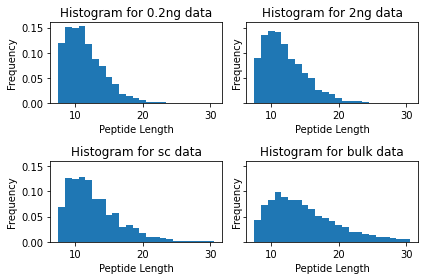

In [11]:
# Keeping all data
plot_peptide_length_distribution(peptide_lengths, "figures/length_distributions_before_filtering.pdf")

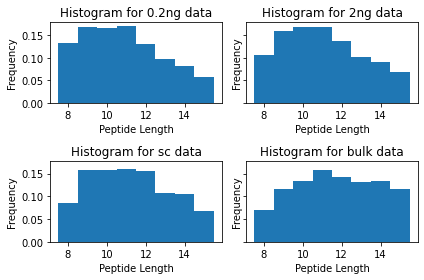

In [12]:
# Restricting to where we have 8 <= peptide_length <= 15
plot_peptide_length_distribution(peptide_lengths[(peptide_lengths["peptide_length"] <= 15) & (peptide_lengths["peptide_length"] >= 8)])

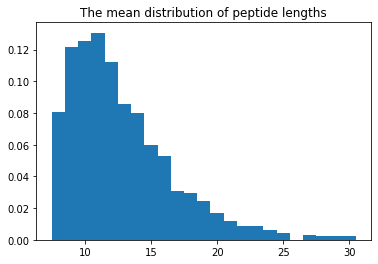

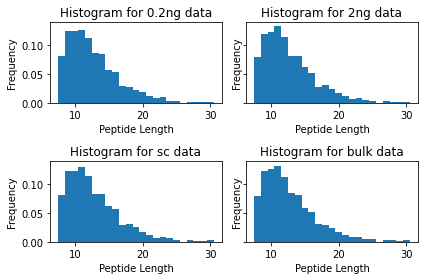

Percentage of each data type that is kept: [('0.2ng', 0.09439452289259735), ('2ng', 0.1470356423504685), ('sc', 0.33256300209089906), ('bulk', 0.5499990501700196)]


In [13]:
# We try to normalize each distribution to a "mean distribution"
random_state = np.random.RandomState(8675309)
mean_dist = find_mean_distribution(peptide_lengths)
chosen_peptides, keep_percentages = sample_to_distribution(peptide_lengths, mean_dist, random_state)

plot_distribution(mean_dist, (peptide_lengths["peptide_length"].min(), peptide_lengths["peptide_length"].max()))
plot_peptide_length_distribution(chosen_peptides)
print(f"Percentage of each data type that is kept: {keep_percentages}")

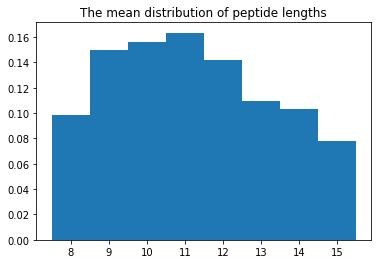

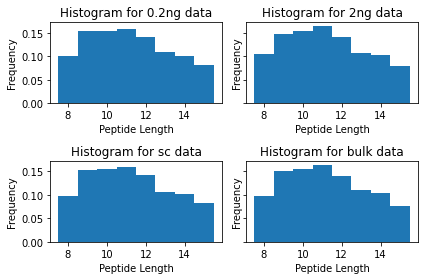

Percentage of each data type that is kept: [('0.2ng', 0.7085665496632199), ('2ng', 0.886229390312805), ('sc', 0.8081564710778194), ('bulk', 0.7175446563729942)]


In [14]:
# What we have above is looking good, but we're losing a lot of data, especially single cell data, which isn't ideal. Let's restrict to
# between 8 and 15 and also try to normalize each distribution to the "mean distribution"
random_state = np.random.RandomState(8675309)
clamped_lengths = peptide_lengths[(peptide_lengths["peptide_length"] <= 15) & (peptide_lengths["peptide_length"] >= 8)]
mean_dist = find_mean_distribution(clamped_lengths)
cleaned_peptides, keep_percentages = sample_to_distribution(clamped_lengths, mean_dist, random_state)

plot_distribution(mean_dist, (clamped_lengths["peptide_length"].min(), clamped_lengths["peptide_length"].max()), "figures/mean_filtered_distribution.pdf")
plot_peptide_length_distribution(cleaned_peptides, "figures/peptide_length_distributions_after_filtering.pdf")
print(f"Percentage of each data type that is kept: {keep_percentages}")

In [15]:
cleaned_peptides = cleaned_peptides.reset_index()
cleaned_peptides

df = raw_df.merge(cleaned_peptides[["scan", "type"]], how="inner", on=["scan","type"])
df

,scan,peptide,file_name,Ion Type,Ion Number,sector,Intensity,type
0,19588,TSFFQALGITTK,Ex_Auto_J3_30umTB_02ngQC_60m_1-calib,b,1,1,none,0.2ng
1,19588,TSFFQALGITTK,Ex_Auto_J3_30umTB_02ngQC_60m_1-calib,b,2,1,low,0.2ng
2,19588,TSFFQALGITTK,Ex_Auto_J3_30umTB_02ngQC_60m_1-calib,b,3,1,low,0.2ng
3,19588,TSFFQALGITTK,Ex_Auto_J3_30umTB_02ngQC_60m_1-calib,b,4,1,none,0.2ng
4,19588,TSFFQALGITTK,Ex_Auto_J3_30umTB_02ngQC_60m_1-calib,b,5,2,none,0.2ng
...,...,...,...,...,...,...,...,...
2946725,96485,GFFGFPGPR,OR11_20160122_PG_HeLa_CVB3_CT_C-calib,y,4,1,medium,bulk
2946726,96485,GFFGFPGPR,OR11_20160122_PG_HeLa_CVB3_CT_C-calib,y,5,1,low,bulk
2946727,96485,GFFGFPGPR,OR11_20160122_PG_HeLa_CVB3_CT_C-calib,y,6,2,medium,bulk
2946728,96485,GFFGFPGPR,OR11_20160122_PG_HeLa_CVB3_CT_C-calib,y,7,2,low,bulk


# Perform Analysis

In [16]:
# Make the figure 3 with the cleaned data
df_b = df.loc[df["Ion Type"] == "b", ["type", "Intensity", "sector"]]
df_y = df.loc[df["Ion Type"] == "y", ["type", "Intensity", "sector"]]


In [17]:
fig_df_b = get_proportions_df(df_b)
fig_df_y = get_proportions_df(df_y)

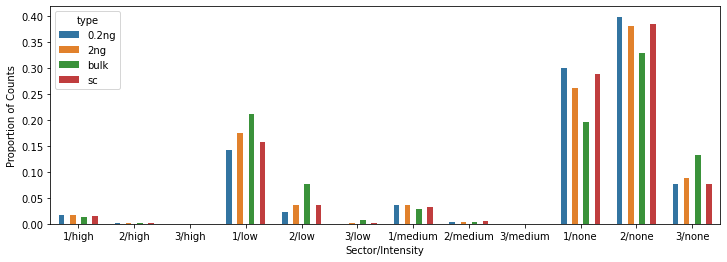

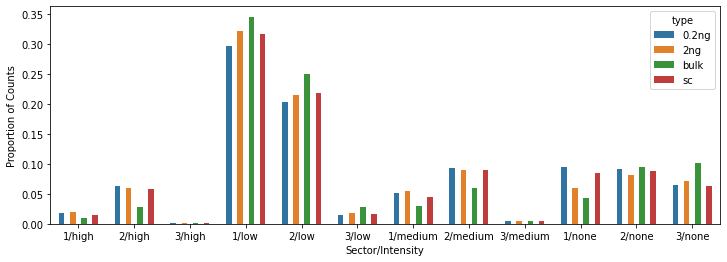

In [18]:
make_figure(fig_df_b, "sector_intensity_counts_b_ions.pdf")
make_figure(fig_df_y, "sector_intensity_counts_y_ions.pdf")

  0%|          | 0/10000 [00:00<?, ?it/s]

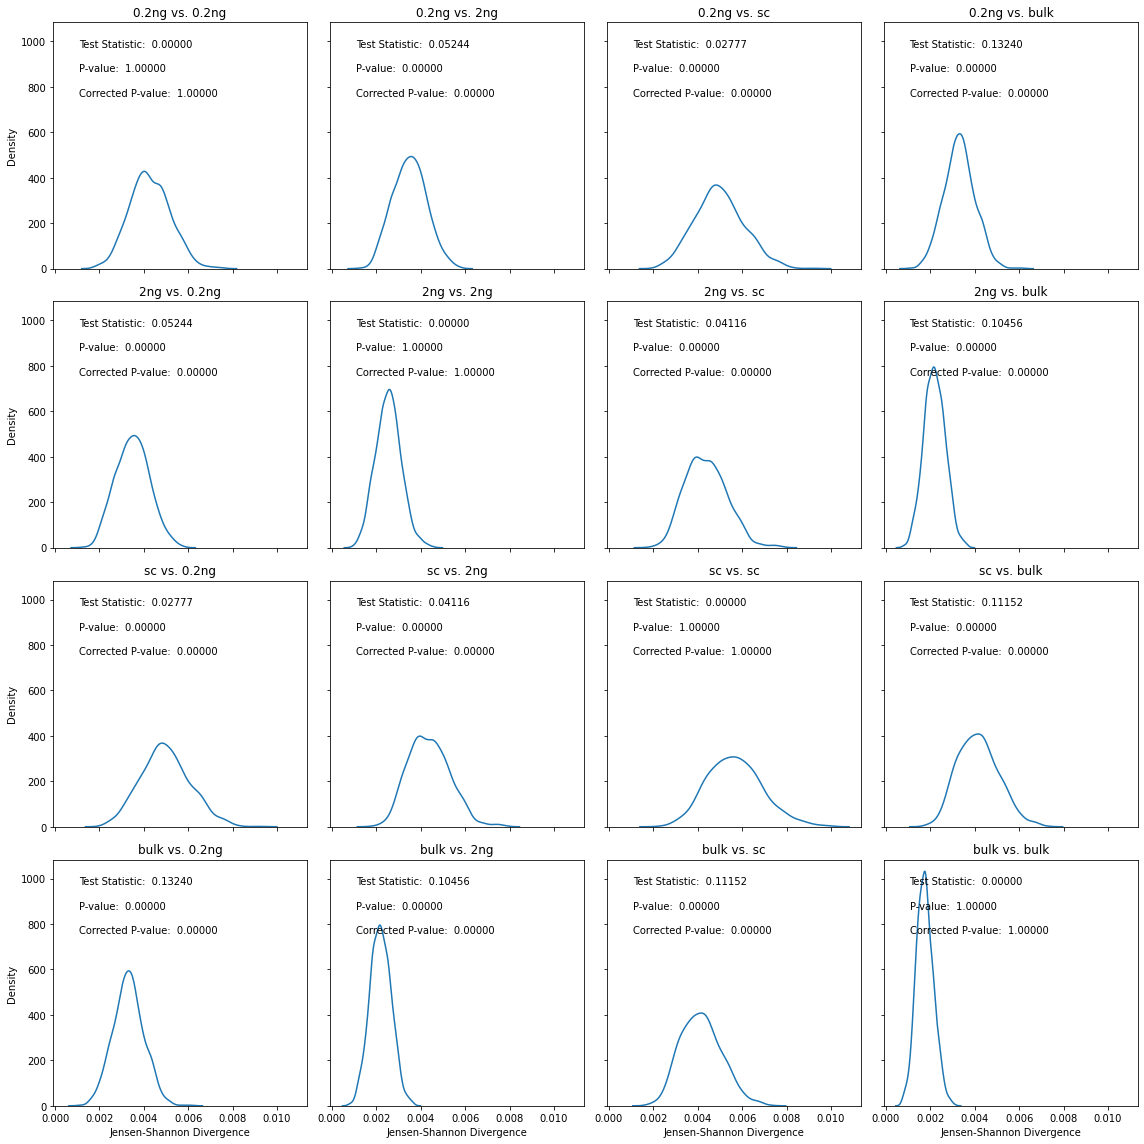

  0%|          | 0/10000 [00:00<?, ?it/s]

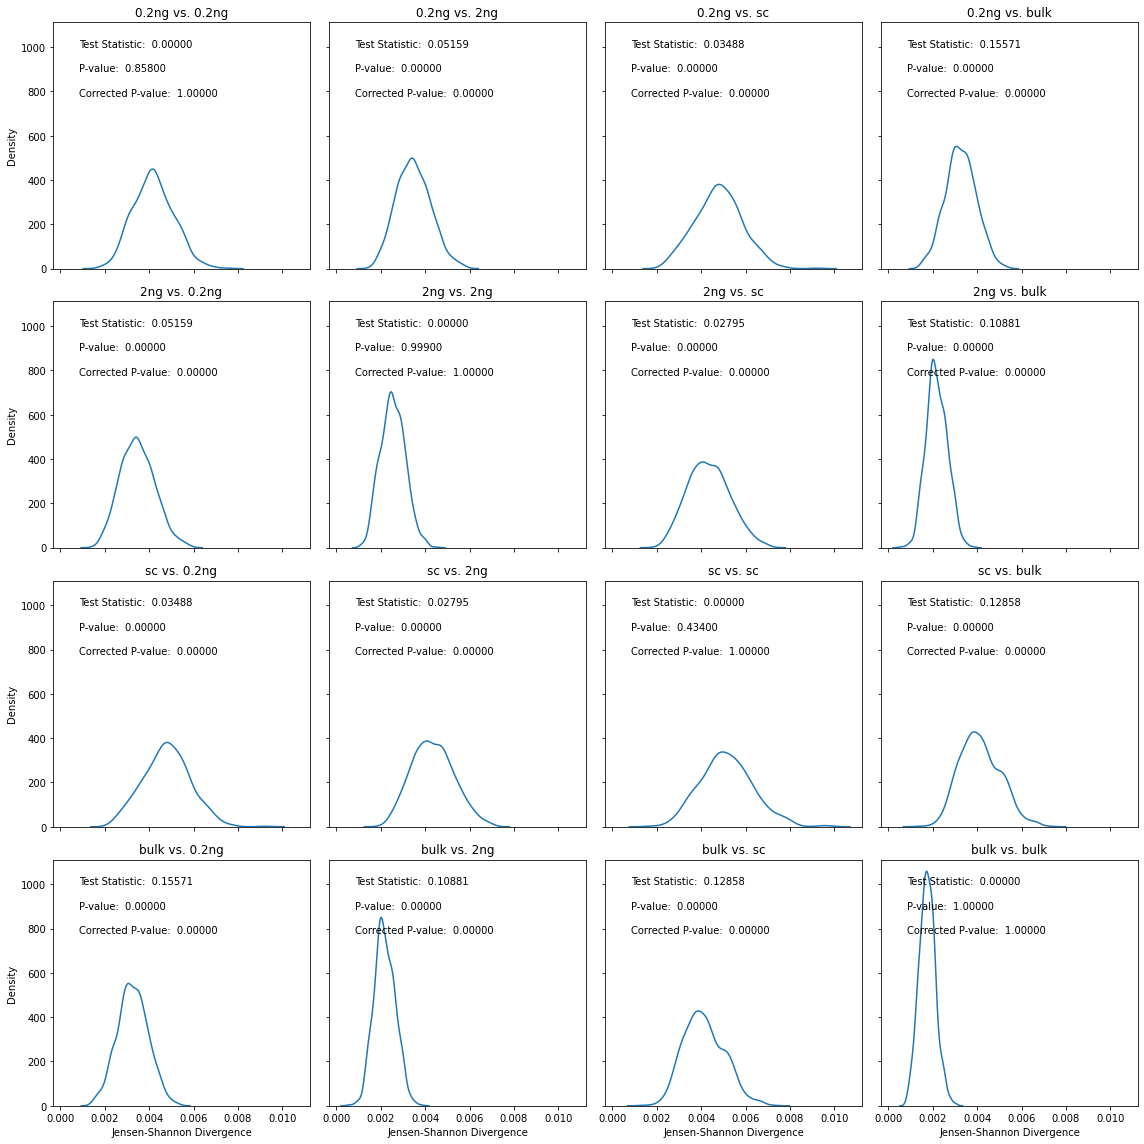

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [67]:
random_state = np.random.RandomState(8)

multiple_permutation_test(df_y, 1000, random_state, figure_out="figures/permutation_test_y.pdf")
multiple_permutation_test(df_b, 1000, random_state, figure_out="figures/permutation_test_b.pdf")